# Processing the industry end use data published by countries (UK, AT, DE, and CH)

In [1]:
import sys
import os

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append('../../src/construct/')
import util
import annual_heat_demand

idx = pd.IndexSlice

data_path = '../../data/industry/'

In [50]:
# Mapping of categories to normalise each dataset
DE_subsectors = {
    'Gew. v. Steinen u. Erden': 'Mining & quarrying',
    'Ernährung und Tabak': 'Food, beverages & tobacco',
    'Papiergewerbe': 'Paper, pulp & printing',
    'Grundstoffchemie': 'Chemical & petrochemical',
    'Sonst. chemische Industrie': 'Chemical & petrochemical',
    'Gummi- u. Kunststoffwaren': 'Not elsewhere specified (industry)',
    'Glas u. Keramik': 'Non-metallic minerals',
    'Verarb. v. Steine u. Erden': 'Non-metallic minerals',
    'Metallerzeugung ': 'Metals',
    'NE-Metalle, -gießereien': 'Metals',
    'Metallbearbeitung': 'Metals',
    'Maschinenbau': 'Machinery',
    'Fahrzeugbau': 'Transport equipment',
    'Sonst. Verarbeitendes Gewerbe': 'Not elsewhere specified (industry)',
}
DE_end_uses = {
    'Beleuchtung': 'end_use_electricity',
    'Elektrische Antriebe (Druckluft)': 'mechanical',
    'Elektrische Antriebe (Pumpen)': 'mechanical',
    'Sonstige Mechanische Energie': 'mechanical',
    'IKT': 'end_use_electricity',
    'Klimakälte': 'space_cooling',
    'Prozesskälte': 'process_cooling',
    'Prozesswärme': 'process_heating',
    'Raumwärme': 'space_heating',
    'Warmwasser': 'water_heating'
}
DE_carriers = {
    'Erneuerbare': 'renewable_heat',
    'Fernwärme': 'district_heat',
    'Heizöl (Leicht)': 'oil',
    'Heizöl (Schwer)': 'oil',
    'Kohlen': 'solid_fuel',
    'Naturgase': 'natural_gas',
    'Sonstige Brennstoffe': 'other',
    'Sonstige Gase': 'manufactured_gas',
    'Sonstige Mineralöle': 'oil',
    'Strom (f. Anhang)': 'electricity',
}

UK_subsectors = {
    'Iron, steel, non ferrous metals': 'Metals',
    'chemicals':  'Chemical & petrochemical',
    'electrcial engineering': 'Machinery',
    'food, drink and tobacco': 'Food, beverages & tobacco',
    'mechanical engineering': 'Machinery',
    'mineral products': 'Non-metallic minerals',
    'other industries': 'Not elsewhere specified (industry)',
    'printing, publishing': 'Paper, pulp & printing',
    'textiles, leather, etc': 'Textile & leather',
    'vehicles': 'Transport equipment'
}
UK_end_uses = {
    'Compressed Air': 'mechanical', 
    'Drying / Separation': 'process_heating', 
    'High temperature process': 'process_heating', 
    'Lighting': 'end_use_electricity', 
    'Low Temperature Process': 'process_heating', 
    'Motors': 'mechanical', 
    'Other': 'other', 
    'Refrigeration': 'process_cooling', 
    'Space Heating': 'space_heating'
}
UK_carriers = {
    'Electricity': 'electricity', 
    'Natural Gas': 'natural_gas', 
    'Oil': 'oil', 
    'Solid Fuel': 'solid_fuel'
}

AT_carriers = {
    'Ambient and solar heat': 'renewable_heat', # 'Renewable heat',
    'Biofuels': 'solid_fuel', # 'Primary solid biofuels',
    'Blast furnace gas': 'manufactured_gas', # 'Manufactured gas',
    'Coke oven coke': 'solid_fuel', # 'Solid fossil fuels',
    'Coke oven gas': 'manufactured_gas', # 'Manufactured gas',
    'Diesel': 'oil', # 'Oil and petroleum products',
    'District heat': 'district_heat', # 'District heat',
    'Electricity': 'electricity', # 'Electricity',
    'Fuel oil': 'oil', # 'Oil and petroleum products',
    'Fuel wood': 'solid_fuel', # 'Primary solid biofuels',
    'Gas oil': 'oil', # 'Oil and petroleum products',
    'Gasoline': 'oil', # 'Oil and petroleum products',
    'Hard coal': 'solid_fuel', # 'Solid fossil fuels',
    'Kerosene': 'oil', # 'Oil and petroleum products',
    'LPG': 'oil', # 'Oil and petroleum products',
    'Lignite': 'solid_fuel', # 'Solid fossil fuels',
    'Natural gas': 'natural_gas', # 'Natural gas',
    'Other energy sources': 'other', # 'Other',
    'Peat': 'solid_fuel', # 'Peat',
    'Petrol coke': 'oil', # 'Oil and petroleum products',
    'Waste': 'waste', # 'Waste'
}
AT_end_uses = {
    'air_condition': 'space_cooling',
    'cooling': 'process_cooling',
    'drying': 'process_heating',
    'electochemical_purposes': 'end_use_electricity',
    'industrial_furnaces': 'process_heating',
    'lightning_computing': 'end_use_electricity',
    'other': 'other',
    'space_heating': 'space_heating'  ,
    'stationary_engines': 'mechanical',
    'traction': 'mechanical',
    'vapor_production': 'process_heating',
    'water_heating': 'water_heating'
}
AT_subsectors = {
    'Chemical and petrochemical industry': 'Chemical & petrochemical',
    'Construction': 'Construction',
    'Food, tabacco and beverages': 'Food, beverages & tobacco',
    'Iron and steel': 'Metals',
    'Machinery': 'Machinery',
    'Mining and quarrying': 'Mining & quarrying',
    'Non ferrous metals': 'Metals',
    'Non metalic minerals': 'Non-metallic minerals',
    'Non specified industry': 'Not elsewhere specified (industry)',
    'Paper, pulp and print': 'Paper, pulp & printing',
    'Textiles and leather': 'Textile & leather',
    'Transport equipment': 'Transport equipment',
    'Wood and wood products': 'Wood & wood products'
}

CH_end_uses = {
    'Raumwärme': 'space_heating',
    'Warmwasser': 'water_heating',
    'Prozesswärme': 'process_heating',
    'Beleuchtung': 'end_use_electricity',
    'Klima, Lüftung, HT': 'space_cooling',
    'I&K, Unterhaltung': 'end_use_electricity',
    'Antriebe, Prozesse': 'end_use_electricity',
    'sonstige': 'other'
}

In [3]:
# Extract Austrian data
def get_at_end_use_df(year=None, region=None):
    files = {
        'AT': '066288',  # NUTS0
        'AT11': '066289',  # NUTS2
        'AT12': '066291',  # NUTS2
        'AT13': '066297',  # NUTS2
        'AT21': '066290',  # NUTS2
        'AT22': '066294',  # NUTS2
        'AT31': '066292',  # NUTS2
        'AT32': '066293',  # NUTS2
        'AT33': '066295',  # NUTS2
        'AT34': '066296'  # NUTS2
    }
    if region is not None:
        files = {region: files[region]}
    if year is not None:
        years = [year]
    else:
        years = range(2005, 2018)
    end_uses = []
    
    for region, filecode in files.items():
        for year in years:
            _end_use_demand = pd.read_excel(
                f'https://www.statistik.at/wcm/idc/idcplg?IdcService=GET_NATIVE_FILE&RevisionSelectionMethod=LatestReleased&dDocName={filecode}', 
                sheet_name=f'NEA {year}', usecols="U:AI", skiprows=30, header=None
            ).dropna()
            table_ends = _end_use_demand[_end_use_demand[20] == 'Peat'].index
            dfs = []

            for i in range(0, len(table_ends)):
                if i == 0:
                    _df = _end_use_demand.loc[:table_ends[i] + 1]
                else:
                    _df = _end_use_demand.loc[table_ends[i - 1] + 1:table_ends[i] + 1]

                _df = _df.set_index(20).drop(['Shares', 'TOTAL', 0], errors='ignore')
                _df.columns = _df.iloc[0].values
                _df.rename(
                    columns={'Indust. furnaces': 'Industrial furnaces',
                            'of which electochemical purp.': 'of which electochemical purposes'}, 
                    inplace=True
                )
                _df.index.set_names('carrier_name', inplace=True)
                _df = _df.assign(cat_name=_df.iloc[0].name)
                _df = _df.drop(_df.iloc[0].name).drop(['Other', 'Total'], axis=1)
                _df.columns = (
                    _df.columns
                    .str.lower()
                    .str.replace("of which ", "")
                    .str.replace(" & ", "_")
                    .str.replace(" ", "_")
                )
                _df = _df.set_index('cat_name', append=True)

                dfs.append(_df)
            end_uses.append(
                pd.concat(dfs, sort=True)
                .sort_index()
                .assign(region=region, year=year, unit='TJ')
                .set_index(['region', 'year', 'unit'], append=True)
            )
    return pd.concat(end_uses, sort=True)

In [4]:
# Extract German industry data (file comes from contact in ISI Fraunhofer)
def get_de_end_use_df():
    dfs = []
    for year in range(2013, 2019):
        sheet = pd.read_excel(
            data_path + '/Drucktabellen Anwendungsbilanzen 2013-2018.xlsx', sheet_name=f'IND_{year}'
        )
        table_ends = sheet[sheet['Unnamed: 0'] == 'Summe'].index
        table_ends = table_ends.insert(0, 1)
        for i in range(0, len(table_ends) - 1):
            _df = sheet.iloc[table_ends[i] + 1:table_ends[i + 1] + 1].dropna(how='all').dropna(how='all', axis=1)
            _subsector = _df.iloc[0, 0]
            _cols = _df.iloc[1].dropna().values
            _idx = _df.dropna().iloc[:, 0]
            if _subsector.startswith('Strom'):
                _cols_lim = list(_cols).index('Summe')
                _df = _df.dropna().set_index('Unnamed: 0').rename_axis(index='cat_name')
                _df = _df.assign(carrier_name=_subsector).set_index('carrier_name', append=True)
                _df = _df.iloc[:, :_cols_lim]
                _df.columns = _cols[:_cols_lim]
            else:
                _df = _df.dropna().set_index('Unnamed: 0').rename_axis(index='carrier_name')
                _df = _df.assign(cat_name=_subsector).set_index('cat_name', append=True)
                _df.columns = _cols

            _df.rename_axis(columns='end_use', inplace=True)
            _df = _df.drop('Summe', axis=0, errors='ignore').drop('Summe', axis=1, errors='ignore')
            _df = _df.assign(year=year).set_index('year', append=True)
            _df = _df.assign(unit='PJ').set_index('unit', append=True)
            dfs.append(_df.stack().reorder_levels(['cat_name', 'carrier_name', 'end_use', 'year', 'unit']))
    return pd.concat(dfs)

In [5]:
# Extract UK industry data
def get_uk_end_use_df():
    sheet = pd.read_excel(
        'https://www.gov.uk/government/uploads/system/uploads/attachment_data/file/820752/2019_End_use_tables.xlsx', 
        sheet_name='Table U4', skiprows=4
    )
    dfs = []
    table_ends = sheet[sheet['Unnamed: 3'] == 'Total industries'].index
    table_ends = table_ends.insert(0, 0)
    carriers = sheet.iloc[0, :]
    for i in range(0, len(table_ends) - 1):
        _df = sheet.iloc[table_ends[i] + 1:table_ends[i + 1] + 1].dropna(how='all').dropna(how='all', axis=1)

        year = _df.iloc[0, 0]
        _cols = carriers.dropna().reset_index()
        _cols['end_use'] = _cols['index'].where(_cols['index'].str.find('Unnamed') == -1).bfill()
        _cols = _cols.set_index([0, 'end_use']).index

        _df = _df[_df['Unnamed: 3'].str.find('Total') > -1].set_index('Unnamed: 3').dropna(axis=1)
        _df.index = _df.index.str.replace('Total ', '').rename('cat_name')
        _df = _df.assign(year=year).set_index('year', append=True)
        _df = _df.assign(unit='ktoe').set_index('unit', append=True)
        _df.columns = _cols
        _df = _df.drop('Total', axis=1, level=0).drop('Total ', axis=1, level=1)

        _df.rename_axis(columns=['carrier_name', 'end_use'], inplace=True)

        dfs.append(_df.stack([0, 1]).reorder_levels(['cat_name', 'carrier_name', 'end_use', 'year', 'unit']))
    return pd.concat(dfs)

In [59]:
# Extract CH industry data
def get_ch_end_use_df():
    ch_end_use_excel_path = '../../data/automatic/ch_hh_end_use.xlsx'
    dfs = []
    for k, v in {
        'Tabelle 29': ('industry', 'fuel'), 
        'Tabelle30': ('industry', 'electricity')
    }.items():
        _df = (
            annual_heat_demand.get_ch_sheet(ch_end_use_excel_path, k, skipfooter=4, translation=CH_end_uses)
            .assign(carrier_name=v[1], cat_name=v[0], unit='PJ')
            .set_index(['carrier_name', 'cat_name', 'unit'], append=True)
            .stack()
            .rename_axis(index=['end_use', 'carrier_name', 'cat_name', 'unit', 'year'])
            .reorder_levels(['cat_name', 'carrier_name', 'end_use', 'year', 'unit'])
        )
        dfs.append(_df)
    return pd.concat(dfs)

In [7]:
# Normalise all the data and save to file
if 'published_industry_end_use_consumption.csv' not in os.listdir(data_path):
    at_end_use_tdf = (
        get_at_end_use_df()
        .xs(('TJ', 'AT'), level=('unit', 'region'))
        .apply(util.tj_to_twh)
        .stack()
        .unstack('year')
        .groupby([AT_carriers, AT_subsectors, AT_end_uses], level=[0, 1, 2]).sum()
        .stack()
        .rename_axis(index=['carrier_name', 'cat_name', 'end_use', 'year'])
        .reorder_levels(['cat_name', 'carrier_name', 'end_use', 'year'])
    )
    de_end_use_tdf = (
        get_de_end_use_df()
        .xs(('PJ'), level=('unit'))
        .apply(util.pj_to_twh)
        .unstack('year')
        .groupby([DE_subsectors, DE_carriers, DE_end_uses], level=[0, 1, 2]).sum()
        .stack()
    )
    uk_end_use_tdf = (
        get_uk_end_use_df()
        .xs(('ktoe'), level=('unit'))
        .apply(util.ktoe_to_twh)
        .unstack('year')
        .groupby([UK_subsectors, UK_carriers, UK_end_uses], level=[0, 1, 2]).sum()
        .stack()
    )
    ch_end_use_tdf = (
        get_ch_end_use_df()
        .xs(('pj'), level=('unit'))
        .apply(util.pj_to_twh)
        .unstack('year')
        .stack()
    )
    end_use_tdf = pd.concat([at_end_use_tdf, de_end_use_tdf, uk_end_use_tdf, ch_end_use_tdf], keys=['AT', 'DE', 'UK', 'CH'], names=['country_code'])
    end_use_tdf = end_use_tdf.where(end_use_tdf > 0).dropna()
    end_use_tdf.to_csv(data_path + '/published_industry_end_use_consumption.csv')
else:
    end_use_tdf = pd.read_csv(data_path + '/published_industry_end_use_consumption.csv', index_col=[0, 1, 2, 3, 4], squeeze=True)

/Users/brynmorp/miniconda3/envs/euro-spores/lib/python3.7/site-packages/pandas/core/generic.py:3936: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


NameError: name 'ch_end_use' is not defined

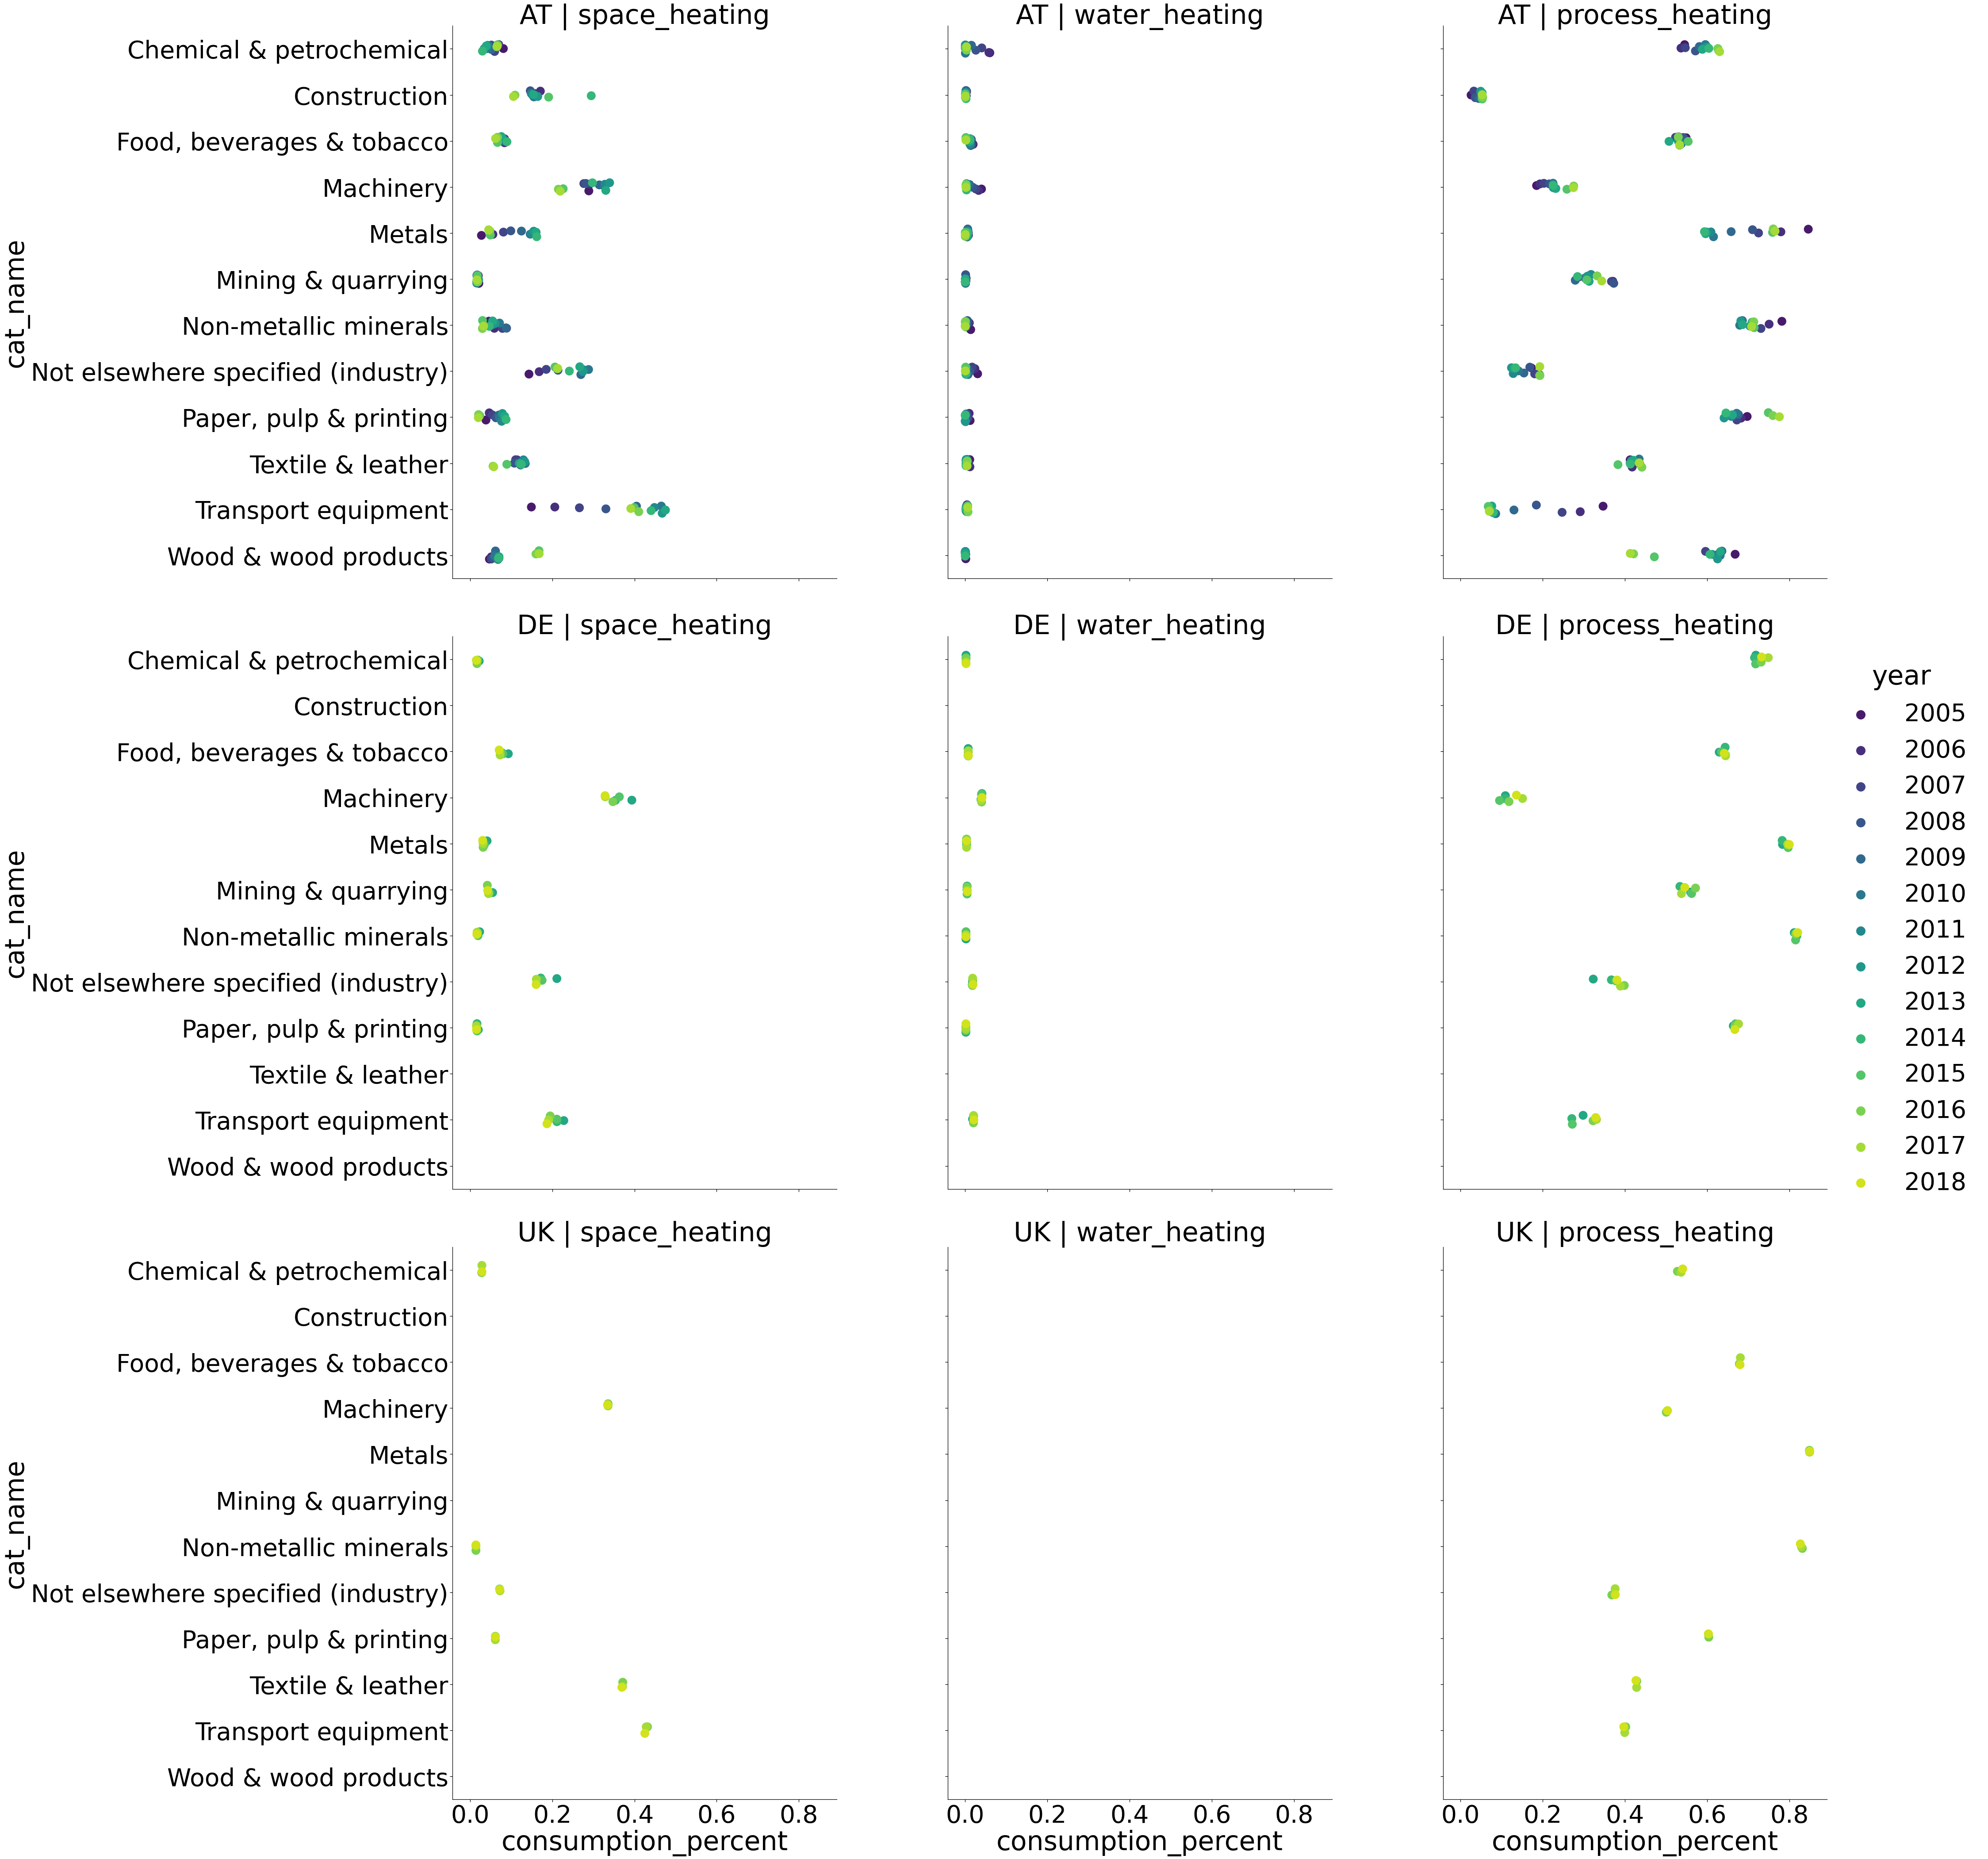

In [18]:
# Plot percentage contribution of heating end uses to total energy consumption for each year, country, and industry subsector. 
# CH is ignored here
end_use_consumption_percent = (
    end_use_tdf
    .sum(level=['country_code', 'cat_name', 'end_use', 'year'])
    .div(end_use_tdf.sum(level=['country_code', 'cat_name', 'year']))
    .drop('CH', level=0)
)
with sns.plotting_context("notebook", font_scale=5):
    g = sns.catplot(
        data=end_use_consumption_percent.filter(regex='heating', axis=0).to_frame('consumption_percent').reset_index(), 
        y='cat_name', x='consumption_percent', col="end_use", row='country_code', hue="year",
        hue_order=[i for i in range(2005, 2019)], palette='viridis', legend=True, 
        height=20, aspect=1, s=20
    )
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
    for i in g._legend.legendHandles:
        i._sizes = [400]
    g._legend.set_title('year', prop={'size': 60})

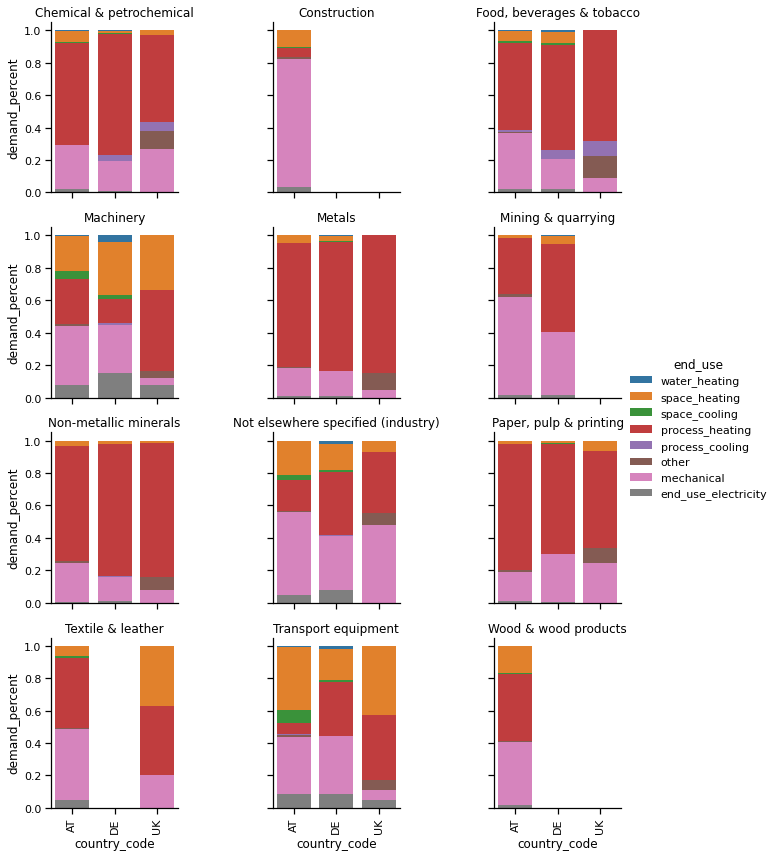

In [27]:
# Plot percentage contribution of different processes to total energy consumption in each industry subsector
# In 2017 for each country seperately
_df = (
    end_use_consumption_percent
    .xs(2017, level='year')
    .unstack(['country_code', 'cat_name'])
    .cumsum() # proxy for a stacked bar
    .stack([0, 1])
    .to_frame('demand_percent')
    .reset_index()
)
with sns.plotting_context("notebook", font_scale=1):
    g = sns.FacetGrid(
        _df, 
        col="cat_name", 
        hue="end_use", 
        hue_order=_df.end_use.unique()[::-1], 
        col_wrap=3
    )
    g.map(
        sns.barplot, 'country_code', 'demand_percent', order=['AT', 'DE', 'UK']
    )
    g.add_legend()
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
foo = [plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]

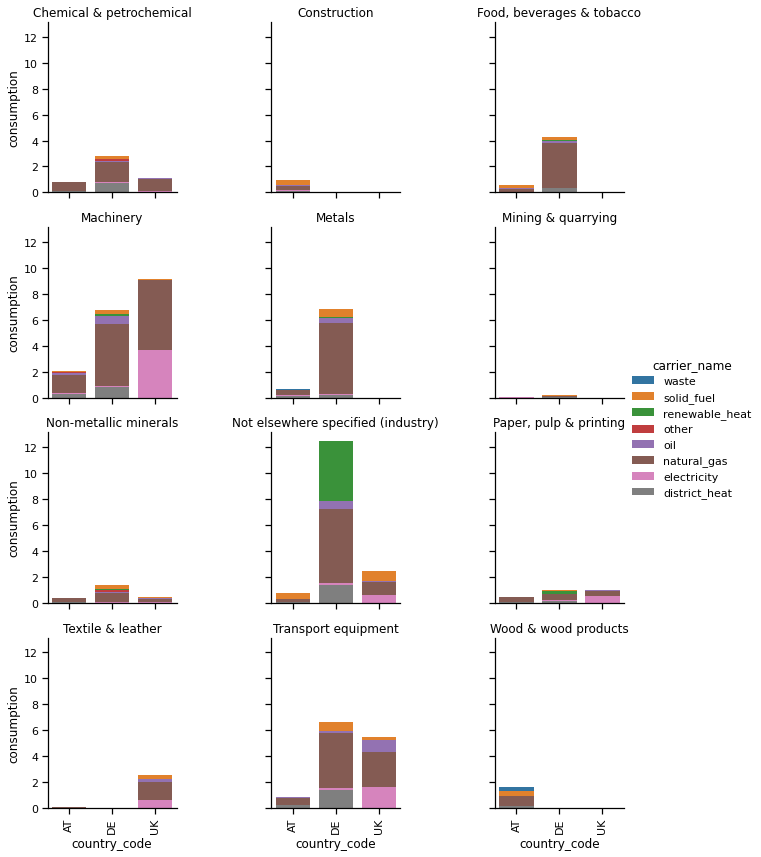

In [26]:
# Plot contribution of different energy carriers to space heating demand
# In 2017 for each country seperately
_df = (
    end_use_tdf
    .xs(('space_heating', 2017), level=('end_use', 'year'))
    .drop('CH', level='country_code')
    .unstack(['country_code', 'cat_name'])
    .cumsum() # proxy for a stacked bar
    .stack([0, 1])
    .to_frame('consumption')
    .reset_index()
)
with sns.plotting_context("notebook", font_scale=1):
    g = sns.FacetGrid(
        _df, 
        col="cat_name", 
        hue="carrier_name",  
        hue_order=_df.carrier_name.unique()[::-1],
        col_wrap=3
    )
    g.map(
        sns.barplot, 'country_code', 'consumption', order=['AT', 'DE', 'UK']
    )
    g.add_legend()
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
foo = [plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]

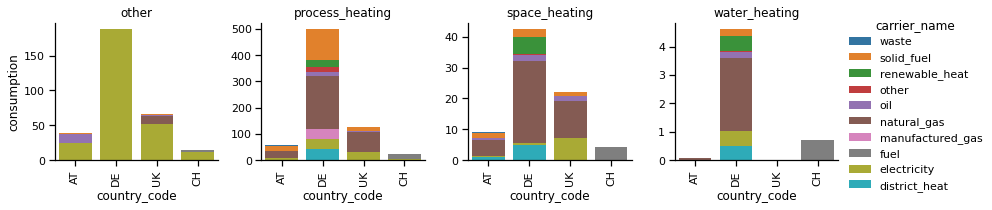

In [35]:
# Compare whole-industry energy consumption per end use and energy carrier in 2017
_df = (
    end_use_tdf
    .xs(2017, level='year')
    .sum(level=['country_code', 'carrier_name', 'end_use'])
    .unstack(['country_code', 'carrier_name'])
    .groupby({
        'process_heating': 'process_heating',
        'space_heating': 'space_heating',
        'water_heating': 'water_heating',
        'space_cooling': 'other', 
        'end_use_electricity': 'other', 
        'mechanical': 'other', 
        'other': 'other',
        'process_cooling': 'other'
    }).sum()
    .rename_axis(index='end_use')
    .stack('carrier_name')
    .unstack('end_use')
    .cumsum()
    .stack([0, 1])
    .to_frame('consumption')
    .reset_index()
)
with sns.plotting_context("notebook", font_scale=1):
    g = sns.FacetGrid(
        _df,
        col="end_use", 
        hue="carrier_name",  
        hue_order=_df.carrier_name.unique()[::-1],
        sharey=False
    )
    g.map(
        sns.barplot, 'country_code', 'consumption', order=['AT', 'DE', 'UK', 'CH']
    )
    g.add_legend()
    g.set_titles(row_template = '{row_name}', col_template = '{col_name}')
foo = [plt.setp(ax.get_xticklabels(), rotation=90) for ax in g.axes.flat]


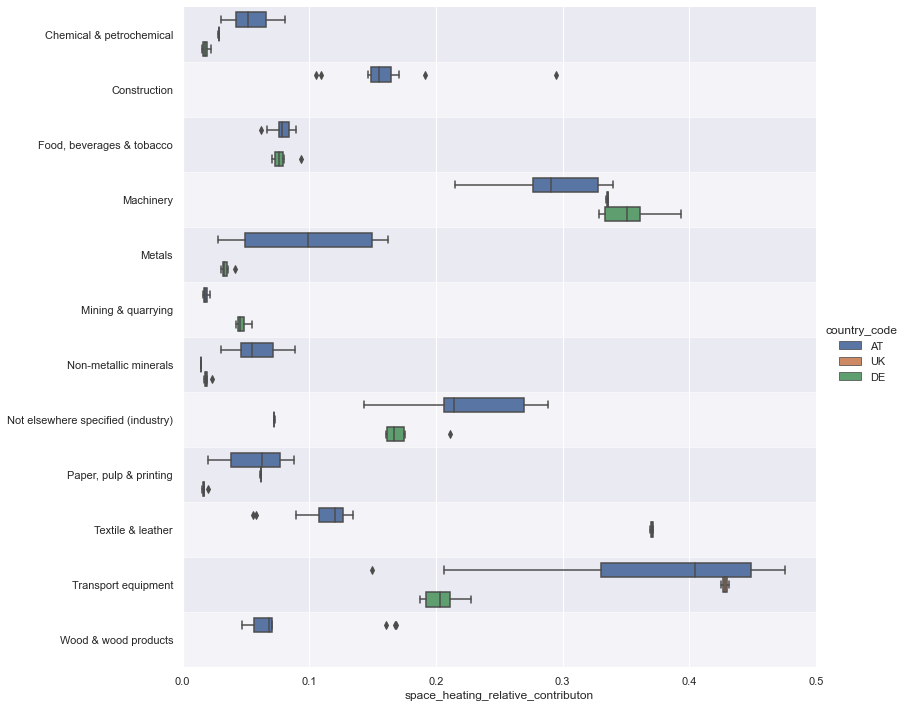

In [1175]:
# Get the contribution of space heating to total end uses
end_use_sh = (
    end_use_tdf
    .sum(level=['country_code', 'cat_name', 'end_use', 'year'])
    .xs('space_heating', level='end_use')
    .div(end_use_tdf.sum(level=['country_code', 'cat_name', 'year']))
)
end_use_sh.reset_index()
# Plot percentage contribution of heating end uses to total demand for each year, country, and industry subsector
with sns.plotting_context("notebook", font_scale=1):
    g = sns.catplot(
        data=end_use_sh.to_frame('space_heating_relative_contributon').reset_index(), 
        y='cat_name', x='space_heating_relative_contributon', 
        hue="country_code", kind='box',
        hue_order=['AT', 'UK', 'DE'], legend=True, 
        height=10, aspect=1.2
    )
    for i in list(range(12))[::2]:
        g.ax.axvspan(xmin=0, xmax=0.5, ymin=i / 12, ymax=(i + 1) / 12, facecolor='white', alpha=0.5, zorder=-1)
    g.ax.set_xlim(0, 0.5)
    g.ax.set_ylabel('')
    #g.set_titles(col_template = '{col_name}')